# Reddit Flair Classification

**Important** 
1. Install pytorch-pretrained-bert
2. Download the pretrained models in current working directory
3. Download the patient dataset in current working directory
4. Converting TF Checkpoints to Pytorch model files
5. Creating output directories for saving model files

NOTE- Most of the code in this notebook is referenced from the [huggingface bert repo](https://github.com/huggingface/pytorch-pretrained-BERT)

**Downloading the train and test sets from S3 buckets**

In [0]:
!wget --no-check-certificate --no-proxy "https://s3.amazonaws.com/redditdata2/train.json"
!wget --no-check-certificate --no-proxy "https://s3.amazonaws.com/redditdata2/test.json"

--2019-02-09 07:45:51--  https://s3.amazonaws.com/redditdata2/train.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.177.173
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.177.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24001937 (23M) [application/json]
Saving to: ‘train.json’

train.json          100%[===================>]  22.89M  25.2MB/s    in 0.9s    

2019-02-09 07:45:52 (25.2 MB/s) - ‘train.json’ saved [24001937/24001937]

--2019-02-09 07:45:53--  https://s3.amazonaws.com/redditdata2/test.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.177.173
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.177.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7902209 (7.5M) [application/json]
Saving to: ‘test.json’

test.json           100%[===================>]   7.54M  13.7MB/s    in 0.5s    

2019-02-09 07:45:54 (13.7 MB/s) - ‘test.json’ saved [7902209/7902209]



**Install pytorch-pretrained-bert, downloading the pretrained model and converting the tensorflow checkpoints to a pytorch state**

In [0]:
!pip install pytorch-pretrained-bert
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

!pytorch_pretrained_bert convert_tf_checkpoint_to_pytorch \
  uncased_L-12_H-768_A-12/bert_model.ckpt \
  uncased_L-12_H-768_A-12/bert_config.json \
  uncased_L-12_H-768_A-12/pytorch_model.bin

    100% |████████████████████████████████| 51kB 3.2MB/s 
--2019-02-08 05:51:12--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   120MB/s    in 3.2s    

2019-02-08 05:51:16 (120 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: 

Importing various libraries

In [0]:
import csv
import os
import logging
import argparse
import six
import random
from tqdm import tqdm, trange

import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


### Basic Exploration

In [0]:
import json

train_json = []

for line in (open('train.json', 'r')):
    train_json.append(json.loads(line))

train = pd.DataFrame.from_records(train_json)

flairs = list(set(train['link_flair_text']))
for flair in flairs:
    print (flair,': ' , len(train[train['link_flair_text'] == flair]))

Non-Political :  1586
Politics :  1587
Food :  1656
[R]eddiquette :  1604
Science/Technology :  1626
Photography :  554
Scheduled :  1596
AskIndia :  1523
Sports :  1719
Business/Finance :  1604
Policy/Economy :  1431


In [0]:
test_json = []

for line in (open('test.json', 'r')):
    test_json.append(json.loads(line))

test = pd.DataFrame.from_records(test_json)

flairs = list(set(test['link_flair_text']))
for flair in flairs:
    print (flair,': ' , len(test[test['link_flair_text'] == flair]))

Non-Political :  414
Sports :  281
Food :  344
[R]eddiquette :  396
Politics :  413
Science/Technology :  374
Photography :  86
Scheduled :  372
AskIndia :  477
Business/Finance :  396
Policy/Economy :  569


In [0]:
print ('Original Size Train: ', (train.shape))
print ('Test: ', (test.shape))

Original Size Train:  (16486, 12)
Test:  (4122, 12)


In [0]:
label_to_id = {'AskIndia': 0,
 'Business/Finance': 1,
 'Food': 2,
 'Non-Political': 3,
 'Photography': 4,
 'Policy/Economy': 5,
 'Politics': 6,
 'Scheduled': 7,
 'Science/Technology': 8,
 'Sports': 9,
 '[R]eddiquette': 10}

id_to_label = {v: k for k, v in label_to_id.items()}
id_to_label

{0: 'AskIndia',
 1: 'Business/Finance',
 2: 'Food',
 3: 'Non-Political',
 4: 'Photography',
 5: 'Policy/Economy',
 6: 'Politics',
 7: 'Scheduled',
 8: 'Science/Technology',
 9: 'Sports',
 10: '[R]eddiquette'}

In [0]:
train.head(1)

,_id,author,comments,created_utc,id,link_flair_text,num_comments,over_18,score,selftext,title,url
0,{'$oid': '5c5959797cf03b047caaa61a'},[deleted],"[Listen to me. \n\n5 years down the line, this...",1524926782,8fkbkh,[R]eddiquette,29,False,50,"So, I didn't do well in JEE Mains, even after ...",[R] Losing the will to live every single day,https://www.reddit.com/r/india/comments/8fkbkh...


In [0]:
train['selftext'] = train['selftext'].astype(str)
test['selftext'] = test['selftext'].astype(str)

empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
  print(empty, len(train[train['selftext'] == empty]))

nan 10262
[deleted] 2428
[removed] 926


In [0]:
train['selftext'] = train['selftext'].apply(lambda x: '' if x in empties else x)
test['selftext'] = test['selftext'].apply(lambda x: '' if x in empties else x)

In [0]:
empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
  print(empty, len(train[train['selftext'] == empty]))

nan 0
[deleted] 0
[removed] 0


In [0]:
train['title'] = train['title'] + ' ' + train['selftext']
test['title'] = test['title'] + ' ' + test['selftext']

Here we will storing the titles and labels in lists. We will then use these to build tsv files required by the DataProcessor.

In [0]:
train_texts = list(train['title'])
test_texts = list(test['title'])

print (len(train_texts))
print (len(test_texts))

16486
4122


In [0]:
train_labels = list()
test_labels = list()

lables=[]

labels = list(train['link_flair_text'])
for label in labels:
  train_labels.append((label_to_id[label]))
  
labels =[]
labels = list(test['link_flair_text'])
for label in labels:
  test_labels.append((label_to_id[label]))
  
print (len(train_labels))
print (len(test_labels))

16486
4122


**Normalizing and preprocessing the titles**

In [0]:
import unicodedata
import re

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
  
train_texts = [normalizeString(i) for i in train_texts]
test_texts = [normalizeString(i) for i in test_texts]

**Removing 0 length titles since they carry no information**

In [0]:
from collections import Counter

text_lens = Counter([len(x) for x in train_texts])
print("Zero-length reviews: {}".format(text_lens[1]))
print("Maximum review length: {}".format(max(text_lens)))

print('Number of reviews before removing outliers: ', len(train_texts))

non_zero_idx = [ii for ii, text in enumerate(train_texts) if len(text) != 1]

train_texts = [train_texts[ii] for ii in non_zero_idx]
train_labels = np.array([train_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(train_texts))

Zero-length reviews: 17
Maximum review length: 21558
Number of reviews before removing outliers:  16486
Number of reviews after removing outliers:  16469


In [0]:
from collections import Counter

text_lens = Counter([len(x) for x in test_texts])
print("Zero-length reviews: {}".format(text_lens[1]))
print("Maximum review length: {}".format(max(text_lens)))
print('Number of reviews before removing outliers: ', len(test_texts))

non_zero_idx = [ii for ii, text in enumerate(test_texts) if len(text) != 1]

test_texts = [test_texts[ii] for ii in non_zero_idx]
test_labels = np.array([test_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(test_texts))

Zero-length reviews: 0
Maximum review length: 23973
Number of reviews before removing outliers:  4122
Number of reviews after removing outliers:  4122


**Building tsv files used by the DataPreprocessor**

In [0]:
!rm -rf dataset
!mkdir dataset/

In [0]:
with open("dataset/train.tsv", "w") as f:
    f.write("sentence    label\n")
    for text, label in zip(train_texts, train_labels):
        f.write(str(text) + "\t" + str(label)+"\n")

In [0]:
with open("dataset/dev.tsv", "w") as f:
    f.write("sentence    label\n")
    for text, label in zip(test_texts, test_labels):
        f.write(str(text) + "\t" + str(label)+"\n")

## Fine tuning the BERT model for out classification task



**Implementing Some Helper Functions**

In [0]:
def convert_to_unicode(text):
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text.decode("utf-8", "ignore")
    elif isinstance(text, unicode):
      return text
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
    raise ValueError("Not running on Python2 or Python 3?")

In [0]:
def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]
                
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        input_mask = [1] * len(input_ids)

        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label_map[example.label]
        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

In [0]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [0]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

def warmup_linear(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 1.0 - x

In [0]:
class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [0]:
class DataProcessor(object):

    def get_train_examples(self, data_dir):
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        raise NotImplementedError()

    def get_labels(self):
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        with open(input_file, "r", encoding='utf-8') as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines

In [0]:
class RedditDataProcessor(DataProcessor):

  def get_train_examples(self, data_dir):
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

  def get_dev_examples(self, data_dir):
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

  def get_labels(self):
    return ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

  def _create_examples(self, lines, set_type):
    examples = []
    for (i, line) in enumerate(lines):
      if i == 0:
        continue
      guid = "%s-%s" % (set_type, i)
      if set_type == "test":
        text_a = convert_to_unicode(line[1])
        label = "0"
      else:
        text_a = convert_to_unicode(line[0])
        label = convert_to_unicode(line[1])
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

### Setting up hyperparameters

In [0]:
!rm -rf output/
!mkdir output
output_dir = 'output'
bert_model = 'uncased_L-12_H-768_A-12'
data_dir = 'dataset'

seed = 42
train_batch_size = 16
gradient_accumulation_steps = 1
max_seq_length = 256
learning_rate = 2e-5
num_train_epochs = 3.0
local_rank = -1
warmup_proportion = 0.1
eval_batch_size = train_batch_size
test_batch_size = train_batch_size

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
train_batch_size = int(train_batch_size / gradient_accumulation_steps)

logger.info("device: {} n_gpu: {}".format(device, n_gpu))
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

02/08/2019 05:59:23 - INFO - __main__ -   device: cuda n_gpu: 1


In [0]:
processor = RedditDataProcessor()
num_labels = 11 #['0', '1']
label_list = processor.get_labels()
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=True)

02/08/2019 05:59:24 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file uncased_L-12_H-768_A-12/vocab.txt


In [0]:
train_examples = None
num_train_steps = None
train_examples = processor.get_train_examples(data_dir)
num_train_steps = int(len(train_examples) / train_batch_size / gradient_accumulation_steps * num_train_epochs)

In [0]:
# Prepare model
model = BertForSequenceClassification.from_pretrained(bert_model,
          cache_dir=PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_{}'.format(local_rank),
          num_labels = num_labels)

model.to(device)
model = torch.nn.DataParallel(model)

02/08/2019 05:59:45 - INFO - pytorch_pretrained_bert.modeling -   loading archive file uncased_L-12_H-768_A-12
02/08/2019 05:59:45 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

02/08/2019 05:59:51 - INFO - pytorch_pretrained_bert.modeling -   Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
02/08/2019 05:59:51 - INFO - pytorch_pretrained_bert.modeling -   Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.

In [0]:
# Prepare optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
t_total = num_train_steps

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=learning_rate,
                     warmup=warmup_proportion,
                     t_total=t_total)

global_step = 0
nb_tr_steps = 0
tr_loss = 0

## Start Training Loop

In [0]:
train_features = convert_examples_to_features(train_examples, label_list, max_seq_length, tokenizer)

logger.info("***** Running training *****")
logger.info("  Num examples = %d", len(train_examples))
logger.info("  Batch size = %d", train_batch_size)
logger.info("  Num steps = %d", num_train_steps)

all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

model.train()

for _ in trange(int(num_train_epochs), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        loss = model(input_ids, segment_ids, input_mask, label_ids)
        loss.backward()

        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (nb_tr_steps % 100 == 0):
          print ('\nCurrent Loss', loss.item(), ' Mean Loss: ', tr_loss/ nb_tr_steps)
        if (step + 1) % gradient_accumulation_steps == 0:
            # modify learning rate with special warm up BERT uses
            lr_this_step = learning_rate * warmup_linear(global_step/t_total, warmup_proportion)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_this_step
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

02/08/2019 06:00:33 - INFO - __main__ -   *** Example ***
02/08/2019 06:00:33 - INFO - __main__ -   guid: train-1
02/08/2019 06:00:33 - INFO - __main__ -   tokens: [CLS] r losing the will to live every single day so i didn t do well in je ##e main ##s even after taking an year off . it s not even average . i attempted around questions and i think that only rd of them will be correct . i couldn t assemble the courage to even check the answer key . the reason ? i have let my parents down . every parent deserves and hopes to see their child excel . but me ? i ve let them down at every damn moment . the last years they ll and i recall it as a disappointment . it hurts a lot when i cannot fulfill the hopes that they had in my dreams . it hurts a lot when i cannot be that kid from the block who s in the best college of the region . it hurts . i take complete responsibility for where i am right now and what i am . no other person is responsible for my failed and worthless existence i did what


Current Loss 2.329841136932373  Mean Loss:  2.4236915349960326



Iteration:  19%|█▉        | 200/1030 [05:16<22:02,  1.59s/it]


Current Loss 1.9508038759231567  Mean Loss:  2.2773089945316314



Iteration:  29%|██▉       | 300/1030 [07:55<19:23,  1.59s/it]


Current Loss 1.4177407026290894  Mean Loss:  2.0517717170715333



Iteration:  39%|███▉      | 400/1030 [10:40<18:03,  1.72s/it]


Current Loss 1.331984281539917  Mean Loss:  1.8880588126182556



Iteration:  49%|████▊     | 500/1030 [13:25<14:30,  1.64s/it]


Current Loss 1.6281300783157349  Mean Loss:  1.7829222809076308



Iteration:  58%|█████▊    | 600/1030 [16:11<11:46,  1.64s/it]


Current Loss 1.3243129253387451  Mean Loss:  1.7038385012745858



Iteration:  68%|██████▊   | 700/1030 [18:58<08:50,  1.61s/it]


Current Loss 1.1511601209640503  Mean Loss:  1.6428326568433216



Iteration:  78%|███████▊  | 800/1030 [21:45<06:13,  1.63s/it]


Current Loss 0.9923834800720215  Mean Loss:  1.589499129280448



Iteration:  87%|████████▋ | 900/1030 [24:30<03:32,  1.64s/it]


Current Loss 1.2218600511550903  Mean Loss:  1.5438764967521033



Iteration:  97%|█████████▋| 1000/1030 [27:16<00:49,  1.65s/it]


Current Loss 1.1026487350463867  Mean Loss:  1.51063305413723



Iteration:  10%|▉         | 100/1030 [02:46<25:21,  1.64s/it]


Current Loss 0.5773861408233643  Mean Loss:  0.9392018255591392



Iteration:  19%|█▉        | 200/1030 [05:31<23:01,  1.66s/it]


Current Loss 0.7641462087631226  Mean Loss:  0.9612508642673493



Iteration:  29%|██▉       | 300/1030 [08:16<20:06,  1.65s/it]


Current Loss 0.6208821535110474  Mean Loss:  0.9795845821499825



Iteration:  39%|███▉      | 400/1030 [11:02<18:05,  1.72s/it]


Current Loss 0.6463689804077148  Mean Loss:  0.9889740671962499



Iteration:  49%|████▊     | 500/1030 [13:48<14:56,  1.69s/it]


Current Loss 0.7274722456932068  Mean Loss:  0.9862378271222114



Iteration:  58%|█████▊    | 600/1030 [16:33<11:46,  1.64s/it]


Current Loss 0.5766717195510864  Mean Loss:  0.9801233073075613



Iteration:  68%|██████▊   | 700/1030 [19:19<09:01,  1.64s/it]


Current Loss 0.5979896783828735  Mean Loss:  0.9680683867420469



Iteration:  78%|███████▊  | 800/1030 [22:04<06:23,  1.67s/it]


Current Loss 0.7344430685043335  Mean Loss:  0.9657560143247247



Iteration:  87%|████████▋ | 900/1030 [24:48<03:31,  1.62s/it]


Current Loss 0.432781457901001  Mean Loss:  0.9673556589417988



Iteration:  97%|█████████▋| 1000/1030 [27:32<00:48,  1.62s/it]


Current Loss 1.168868899345398  Mean Loss:  0.9592523362040519



Iteration:  10%|▉         | 100/1030 [02:45<25:45,  1.66s/it]


Current Loss 0.8850438594818115  Mean Loss:  0.8467750158905983



Iteration:  19%|█▉        | 200/1030 [05:31<23:00,  1.66s/it]


Current Loss 1.0384163856506348  Mean Loss:  0.8501399482786656



Iteration:  29%|██▉       | 300/1030 [08:17<20:06,  1.65s/it]


Current Loss 0.6507776975631714  Mean Loss:  0.852971196770668



Iteration:  39%|███▉      | 400/1030 [11:04<17:08,  1.63s/it]


Current Loss 1.205885410308838  Mean Loss:  0.846357688382268



Iteration:  49%|████▊     | 500/1030 [13:49<14:23,  1.63s/it]


Current Loss 0.8982993364334106  Mean Loss:  0.8354074801504612



Iteration:  58%|█████▊    | 600/1030 [16:35<12:12,  1.70s/it]


Current Loss 1.660020112991333  Mean Loss:  0.8318101598570744



Iteration:  68%|██████▊   | 700/1030 [19:20<09:01,  1.64s/it]


Current Loss 0.7457097768783569  Mean Loss:  0.830417061490672



Iteration:  78%|███████▊  | 800/1030 [22:07<06:24,  1.67s/it]


Current Loss 1.4529889822006226  Mean Loss:  0.8345671543851495



Iteration:  87%|████████▋ | 900/1030 [24:54<03:35,  1.66s/it]


Current Loss 0.854987621307373  Mean Loss:  0.8317608496546746



Iteration:  97%|█████████▋| 1000/1030 [27:41<00:52,  1.75s/it]


Current Loss 0.5998992919921875  Mean Loss:  0.8284170026183129



Epoch: 100%|██████████| 3/3 [1:24:57<00:00, 1696.22s/it]


### Save the trained model

In [0]:
# Save a trained model
model_to_save = model.module if hasattr(model, 'module') else model  
output_model_file = os.path.join(output_dir, "pytorch_model.bin")
torch.save(model_to_save.state_dict(), output_model_file)

In [0]:
# Load a trained model that you have fine-tuned
model_state_dict = torch.load(output_model_file)
model = BertForSequenceClassification.from_pretrained(bert_model, state_dict=model_state_dict, num_labels=num_labels)
model.to(device)

02/08/2019 07:26:53 - INFO - pytorch_pretrained_bert.modeling -   loading archive file uncased_L-12_H-768_A-12
02/08/2019 07:26:53 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertInterme

### Run evaluation on dev set

In [0]:
eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(
    eval_examples, label_list, max_seq_length, tokenizer)

logger.info("***** Running evaluation *****")
logger.info("  Num examples = %d", len(eval_examples))
logger.info("  Batch size = %d", eval_batch_size)

all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)

02/08/2019 07:26:58 - INFO - __main__ -   *** Example ***
02/08/2019 07:26:58 - INFO - __main__ -   guid: dev-1
02/08/2019 07:26:58 - INFO - __main__ -   tokens: [CLS] as ##m ##r autonomous sensory meridian response a new way of indian cooking . so relaxing to watch [SEP]
02/08/2019 07:26:58 - INFO - __main__ -   input_ids: 101 2004 2213 2099 8392 16792 17984 3433 1037 2047 2126 1997 2796 8434 1012 2061 19613 2000 3422 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
02/08/2019 07:26:58 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0

In [0]:
model.eval()
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

results = []

for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
        logits = model(input_ids, segment_ids, input_mask)

    logits = logits.detach().cpu().numpy()
    results.append(logits)
    label_ids = label_ids.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / nb_eval_examples
loss = tr_loss/nb_tr_steps
result = {'eval_loss': eval_loss,
          'eval_accuracy': eval_accuracy,
          'global_step': global_step,
          'loss': loss}

output_eval_file = os.path.join(output_dir, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in sorted(result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

Evaluating: 100%|██████████| 258/258 [04:26<00:00,  1.07it/s]
02/08/2019 07:31:30 - INFO - __main__ -   ***** Eval results *****
02/08/2019 07:31:30 - INFO - __main__ -     eval_accuracy = 0.6710334788937409
02/08/2019 07:31:30 - INFO - __main__ -     eval_loss = 0.9934918261313623
02/08/2019 07:31:30 - INFO - __main__ -     global_step = 3090
02/08/2019 07:31:30 - INFO - __main__ -     loss = 0.8285030601383413


In [0]:
final_preds = []
soft = torch.nn.Softmax()

for result in results:
  for i in result:
    final_preds.append(soft(torch.from_numpy(i)).numpy())

submissions = []
for i in final_preds:
  submissions.append(np.argmax(i))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [0]:
nb_classes = 11

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for t, p in zip(all_label_ids, submissions):
      confusion_matrix[t, p] += 1

confusion_matrix = np.flip(confusion_matrix, 0)

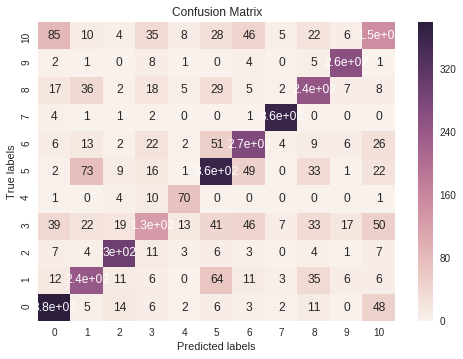

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt     
l = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, ax = ax, ); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(l); ax.yaxis.set_ticklabels(l);

### Evaluating on Custom Inputs 

In [0]:
%time
results = []

sent = "Mumbai man is suing his parents because they brought him into the world without his permission."
test = [InputExample(guid=8, text_a=sent, text_b=None, label='0')]
test_features = convert_examples_to_features(test, label_list, max_seq_length, tokenizer)

all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long).to(device)
all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long).to(device)
all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long).to(device)

model.eval()


with torch.no_grad():
    logits = model(all_input_ids, all_segment_ids, all_input_mask)

logits = logits.detach().cpu().numpy()
results.append(logits)

soft = torch.nn.Softmax()
r = np.argmax(soft(torch.from_numpy(results[0])).numpy())
print ('\n\nLabel: ', id_to_label[r])

02/08/2019 07:34:09 - INFO - __main__ -   *** Example ***
02/08/2019 07:34:09 - INFO - __main__ -   guid: 8
02/08/2019 07:34:09 - INFO - __main__ -   tokens: [CLS] mumbai man is sui ##ng his parents because they brought him into the world without his permission . [SEP]
02/08/2019 07:34:09 - INFO - __main__ -   input_ids: 101 8955 2158 2003 24086 3070 2010 3008 2138 2027 2716 2032 2046 1996 2088 2302 2010 6656 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
02/08/2019 07:34:09 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.11 µs


Label:  Non-Political


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
